In [2]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

# custom
import function

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [3]:
df_train_vals = pd.read_csv('data/training_set_values.csv')
df_train_lab = pd.read_csv('data/training_set_labels.csv')

# Convert all datetime strings to a dattime object
df_train_vals['date_recorded'] = df_train_vals['date_recorded'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y-%M-%d')
    )
df_train_vals['year_recorded'] = df_train_vals['date_recorded'].apply(
    lambda x: x.year
    )


In [4]:
df = pd.merge(df_train_lab, df_train_vals, on='id')

# Summary of the Data

The combined test set has 41 columns, including labels and identifier.
First area of investigation is to check the time span of the data.

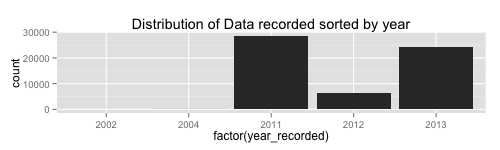

In [5]:
%%R -i df -h 150 -w 500
library(ggplot2)
ggplot(df, aes(x = factor(year_recorded))) + geom_bar() +
    ggtitle('Distribution of Data recorded sorted by year')

We can see that data is recorded from 4 years. Most of the data is from 2011-2013.

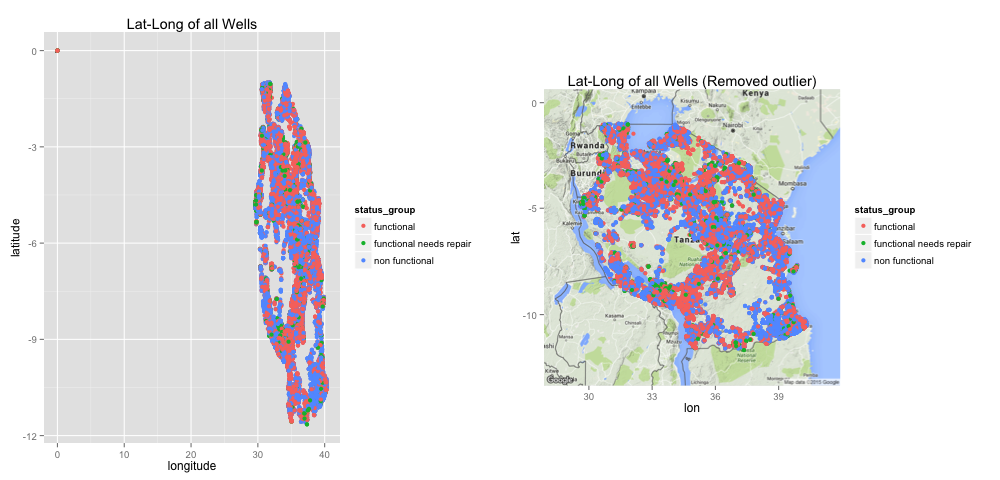

In [6]:
%%R -i df -w 1000
library(ggplot2)
library(ggmap)
library(gridExtra)
tanzania <- get_map('Tanzania', zoom=6)
g1 <- ggplot() + geom_point(data = df, aes(x = longitude, y = latitude, color=status_group)) +
    ggtitle('Lat-Long of all Wells')
g2 <-ggmap(tanzania) + geom_point(data = df[df$longitude != 0, ], aes(x = longitude, y = latitude, color=status_group)) + 
    ggtitle('Lat-Long of all Wells (Removed outlier)')
grid.arrange(g1,g2,ncol=2)

From the geospatial analysis, there are two main conclusions. There are data points across *MANY* locales. Therefore, any feature analysis should not focus on the villages them self as the potential number of labels are as diverse as the data points themself. Instead, there should be a focus on the geospatial location of the data point.

Secondly, there are some clearly misabled data. In the first plot, there are some points centered around (0,0), which are clearly mislabeled as they are not part of tanzania

It also appears that many features reuse the same labels. To filter this out, pick some of the features that do the same thing.

# Predictions

## Feature Engineering

In [69]:
def print_categorical_groups(df, col):
    print col
    print '======'
    print [(g, len(df_g)) for g, df_g in df.groupby(col)]   
    
categories =\
    ['extraction_type', 'management', 'water_quality', 'scheme_management', 'payment', 'source', 'permit', 'public_meeting', 'basin', 'source_class']
for cat in categories:
    print_categorical_groups(df, cat)          

# look at all string type columns

extraction_type
[('afridev', 969), ('cemo', 1), ('climax', 8), ('gravity', 19970), ('india mark ii', 1673), ('india mark iii', 63), ('ksb', 1036), ('mono', 1546), ('nira/tanira', 2797), ('other', 3763), ('other - mkulima/shinyanga', 1), ('other - play pump', 50), ('other - rope pump', 390), ('other - swn 81', 176), ('submersible', 3988), ('swn 80', 2197), ('walimi', 2), ('windmill', 61)]
management
[('company', 652), ('other', 595), ('other - school', 99), ('parastatal', 1096), ('private operator', 1579), ('trust', 75), ('unknown', 354), ('vwc', 26449), ('water authority', 584), ('water board', 2778), ('wua', 2184), ('wug', 2246)]
water_quality
[('coloured', 224), ('fluoride', 167), ('fluoride abandoned', 9), ('milky', 136), ('salty', 3300), ('salty abandoned', 166), ('soft', 33501), ('unknown', 1188)]
scheme_management
[('Company', 1025), ('None', 1), ('Other', 660), ('Parastatal', 1010), ('Private operator', 870), ('SWC', 97), ('Trust', 64), ('VWC', 23046), ('WUA', 2496), ('WUG', 190

In [8]:
df = df[df['construction_year'] > 0]
df['age'] = df['year_recorded']  - df['construction_year']

In [70]:
import sklearn.preprocessing as preprocessing
def encode_categorical_features(df, col):
    '''
    df - the dataframe to manipulate
    col - the categorical column that will be encoded
    %return% - returns a matrix of categorical encoded
    '''
    categ_mat = pd.get_dummies(df[col])
    categ_mat.columns = ['encoded_%s_%s' %(col, c) for c in categ_mat.columns.values]

    return df.join(categ_mat)
def encode_labels(df, col):
    '''
    df - the dataframe to manipulate
    col - the categorical column that will be encoded
    %return% - gives back a series of labels
    '''
    enc = preprocessing.LabelEncoder()
    return enc.fit_transform(df[col])
    
df_raw = df
df_enc = df_raw
for cat in categories:
    df_enc = encode_categorical_features(df_enc, cat)
df_enc['status_group'] = encode_labels(df_enc, 'status_group')

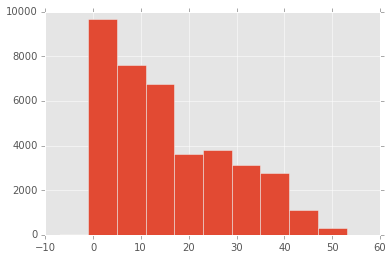

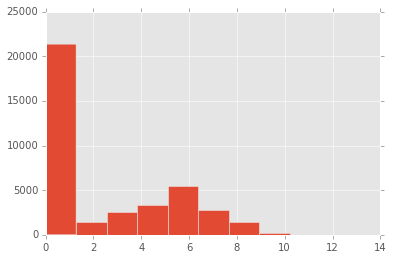

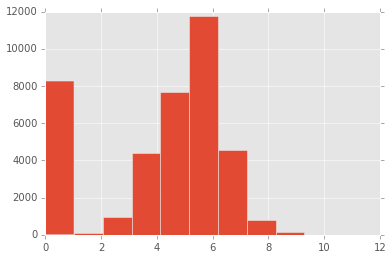

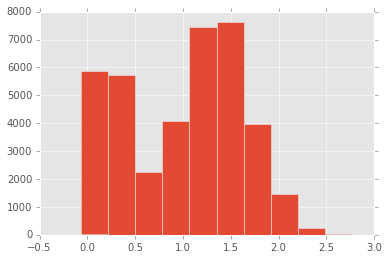

In [82]:
# deal with cont variables
plt.hist(df.age)
plt.figure()
plt.hist(np.log1p(df.amount_tsh))
plt.figure()
plt.hist(np.log1p(df.population))
plt.figure()
plt.hist(df.gps_height/ np.mean(df.gps_height))
df_enc['log_amount_tsh'] = np.log1p(df.amount_tsh)
df_enc['log_population'] = np.log1p(df.population)
df_enc['norm_gps_height'] = df.gps_height/ np.mean(df.gps_height)

In [95]:
# split
import sklearn.cross_validation
y_key = 'status_group'
# active_features = [c for c in df.columns.values if c not in [y_key,'id']]
active_features = [c for c in df_enc._get_numeric_data().columns.values
       if c not in [
            y_key, 
            'id', 
            'longitude', 
            'latitude', 
            'region_code',
            'district_code', 
            'amount_tsh', #log this
            'population', #log1p this
            'construction_year',
            'year_recorded',
            'num_private',
            'gps_height', #normalized
            ]
       ]

x_train, x_test, y_train, y_test = \
    sklearn.cross_validation.train_test_split(df_enc[active_features], df_enc[y_key])
# print '========'   
# print active_features

In [96]:
# Do gradient boosted trees to analyze feature importance
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth = 1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# map feature importance back to the feature
feat =  sorted(
    [(active_features[i], val) for i,val in enumerate(clf.feature_importances_)],
    key=lambda x: x[1],
    )[::-1]
for i in feat:
    print i
print function.metric(y_pred, y_test)

('age', 0.13333333333333341)
('norm_gps_height', 0.089999999999999983)
('log_amount_tsh', 0.083333333333333301)
('encoded_extraction_type_gravity', 0.083333333333333301)
('encoded_basin_Lake Tanganyika', 0.063333333333333311)
('encoded_extraction_type_other', 0.059999999999999984)
('encoded_water_quality_unknown', 0.046666666666666662)
('log_population', 0.040000000000000001)
('encoded_basin_Rufiji', 0.036666666666666667)
('encoded_scheme_management_WUG', 0.029999999999999999)
('encoded_source_class_surface', 0.026666666666666665)
('encoded_basin_Lake Nyasa', 0.026666666666666665)
('encoded_scheme_management_Water Board', 0.026666666666666665)
('encoded_management_private operator', 0.026666666666666665)
('encoded_scheme_management_Water authority', 0.023333333333333331)
('encoded_management_company', 0.023333333333333331)
('encoded_basin_Ruvuma / Southern Coast', 0.019999999999999997)
('encoded_source_lake', 0.019999999999999997)
('encoded_payment_pay monthly', 0.019999999999999997)
(

In [98]:
# Do logistic regression
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression()
lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)


print function.metric(y_pred, y_test)
# map feature importance back to the feature


0.713946035356


In [125]:
red_features = ['norm_gps_height', 'log_amount_tsh', 'log_population']
# make some new feature

red_features = [
        c for c in df_enc.columns.values 
            if c in red_features or 
            c.find('encoded_basin') == 0 or
            c.find('encoded_permit') == 0 or
#             c.find('encoded_source') == 0 or
#             c.find('encoded_scheme_management') == 0 or
            c.find('encoded_source_class') == 0
        ]
df_red = df_enc[red_features]
df_red['extraction_gravity'] = df['extraction_type'] == 'gravity'
df_red['water_quality_unknown'] = df['water_quality'] == 'unknown'
df_red['age_bucket'] = pd.cut(df_enc['age'], bins=[-100, 0, 10, 20, 30, 40, 50, 100])
df_red= encode_categorical_features(df_red, 'age_bucket')
df_red.drop(['age_bucket'], inplace=True, axis=1)
print df_red.columns.values
x_train_red, x_test_red, y_train_red, y_test_red = \
    sklearn.cross_validation.train_test_split(df_red, df_enc[y_key])

['encoded_permit_False' 'encoded_permit_True' 'encoded_basin_Internal'
 'encoded_basin_Lake Nyasa' 'encoded_basin_Lake Rukwa'
 'encoded_basin_Lake Tanganyika' 'encoded_basin_Lake Victoria'
 'encoded_basin_Pangani' 'encoded_basin_Rufiji'
 'encoded_basin_Ruvuma / Southern Coast' 'encoded_basin_Wami / Ruvu'
 'encoded_source_class_groundwater' 'encoded_source_class_surface'
 'encoded_source_class_unknown' 'log_amount_tsh' 'log_population'
 'norm_gps_height' 'extraction_gravity' 'water_quality_unknown'
 'encoded_age_bucket_(-100, 0]' 'encoded_age_bucket_(0, 10]'
 'encoded_age_bucket_(10, 20]' 'encoded_age_bucket_(20, 30]'
 'encoded_age_bucket_(30, 40]' 'encoded_age_bucket_(40, 50]'
 'encoded_age_bucket_(50, 100]']


In [126]:
# Do logistic regression
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression()
lm.fit(x_train_red, y_train_red)
y_pred_red = lm.predict(x_test_red)


print function.metric(y_pred_red, y_test_red)
# map feature importance back to the feature


0.679416933733


In [127]:
# Do gradient boosted trees to analyze feature importance
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(max_depth = 1)
clf.fit(x_train_red, y_train_red)
y_pred_red = clf.predict(x_test_red)

# map feature importance back to the feature
feat =  sorted(
    [(df_red.columns.values[i], val) for i,val in enumerate(clf.feature_importances_)],
    key=lambda x: x[1]
    )[::-1]
for i in feat:
    print i
print function.metric(y_pred_red, y_test_red)

('log_amount_tsh', 0.14666666666666667)
('extraction_gravity', 0.1066666666666667)
('norm_gps_height', 0.1066666666666667)
('encoded_basin_Lake Tanganyika', 0.10333333333333333)
('encoded_age_bucket_(30, 40]', 0.066666666666666638)
('log_population', 0.063333333333333325)
('water_quality_unknown', 0.05666666666666665)
('encoded_age_bucket_(40, 50]', 0.053333333333333323)
('encoded_age_bucket_(0, 10]', 0.049999999999999989)
('encoded_source_class_surface', 0.033333333333333333)
('encoded_basin_Ruvuma / Southern Coast', 0.033333333333333333)
('encoded_age_bucket_(20, 30]', 0.029999999999999999)
('encoded_basin_Lake Nyasa', 0.026666666666666665)
('encoded_basin_Rufiji', 0.023333333333333331)
('encoded_basin_Lake Rukwa', 0.019999999999999997)
('encoded_permit_False', 0.019999999999999997)
('encoded_basin_Lake Victoria', 0.016666666666666666)
('encoded_basin_Internal', 0.016666666666666666)
('encoded_age_bucket_(-100, 0]', 0.013333333333333332)
('encoded_basin_Pangani', 0.013333333333333332

In [129]:
%%R -i df_enc
library(ggplot2)
ggplot(df_enc, aes(x=age, fill=factor(status_group))) + geom_bar() + facet_grid('extraction_type')


Error in eval(expr, envir, enclos) : object 'extraction_type' not found
